In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# set the custom palette
custom_palette = sns.color_palette(['purple','mediumpurple'])
sns.set_palette(custom_palette)

from wordcloud import WordCloud
import string
import nltk
from nltk import bigrams, trigrams, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt') 

import scipy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Input, BatchNormalization, GlobalMaxPool1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yimingzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yimingzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('spam_cleaned.csv')

In [3]:
df.head()

,is_spam,message,num_character,num_word,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


# Preprocessing

## Stemming and Lemmatization

In [4]:
# instantiate WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# define the preprocessing function
def my_tokenizer(message):
    
    # convert the message to lowercase and tokenize
    tokens = word_tokenize(message.lower())
    
    # remove special characters and stopwords, and perform lemmatization in one step
    words = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stopwords.words('english')]
    
    # join the processed tokens back into a single string
    return ' '.join(words)

In [5]:
# test sample
my_tokenizer(df['message'][0])

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [6]:
# apply tokenizer to 'message' column
df['message_transformed'] = df['message'].apply(my_tokenizer)

In [7]:
# instantiate bag of words
bagofwords = CountVectorizer(min_df=5, 
                             tokenizer=my_tokenizer)

# fit and transform
bagofwords.fit(df['message'])
message_transformed = bagofwords.transform(df['message'])

# check shape
message_transformed.shape

(5572, 41)

## Top Words in Spam and Non-spam Messages

### Word Cloud 

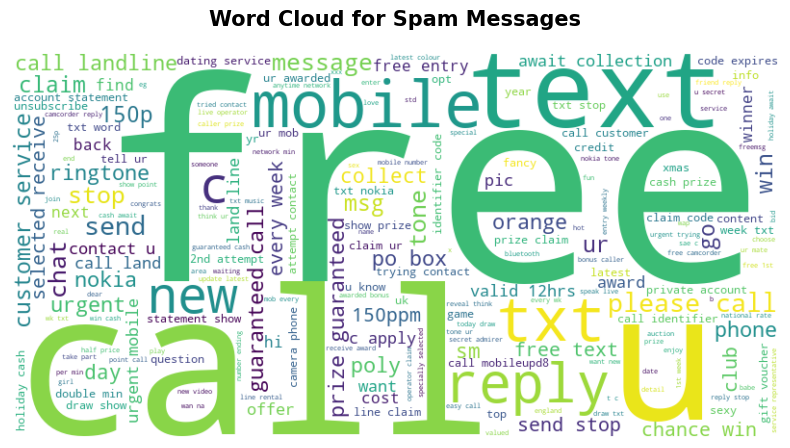

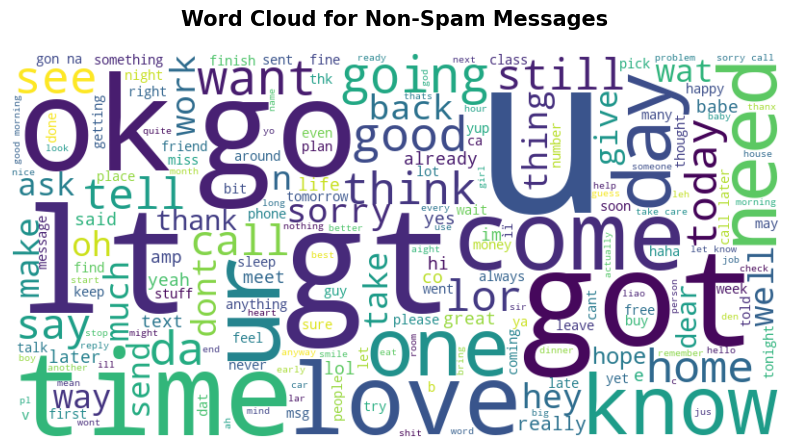

In [8]:
# separate messages into spam and non-spam
spam_messages = df[df['is_spam'] == 1]['message_transformed']
non_spam_messages = df[df['is_spam'] == 0]['message_transformed']

# define word clouds
def generate_wordcloud(text, title):
    
    # combine all texts into one large string
    combined_text = ' '.join(text)
    # create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title,fontweight='bold',fontsize=15,pad=20)
    plt.show()

# generate word clouds for both spam and non-spam messages
generate_wordcloud(spam_messages, 'Word Cloud for Spam Messages')
generate_wordcloud(non_spam_messages, 'Word Cloud for Non-Spam Messages')

### N-Grams Analysis

In [9]:
# define a function to calculate n-gram frequencies
def ngram_frequencies(messages, n):
    
    if n == 1:
        tokens = [token for msg in messages for token in msg.split()]
    elif n == 2:
        tokens = [token for msg in messages for token in bigrams(msg.split())]
    else:
        tokens = [token for msg in messages for token in trigrams(msg.split())]
    
    return FreqDist(tokens)

# split messages into spam and non-spam
spam_messages = df[df['is_spam'] == 1]['message_transformed']
non_spam_messages = df[df['is_spam'] == 0]['message_transformed']

# get frequencies
spam_unigrams = ngram_frequencies(spam_messages, 1)
non_spam_unigrams = ngram_frequencies(non_spam_messages, 1)

spam_bigrams = ngram_frequencies(spam_messages, 2)
non_spam_bigrams = ngram_frequencies(non_spam_messages, 2)

spam_trigrams = ngram_frequencies(spam_messages, 3)
non_spam_trigrams = ngram_frequencies(non_spam_messages, 3)

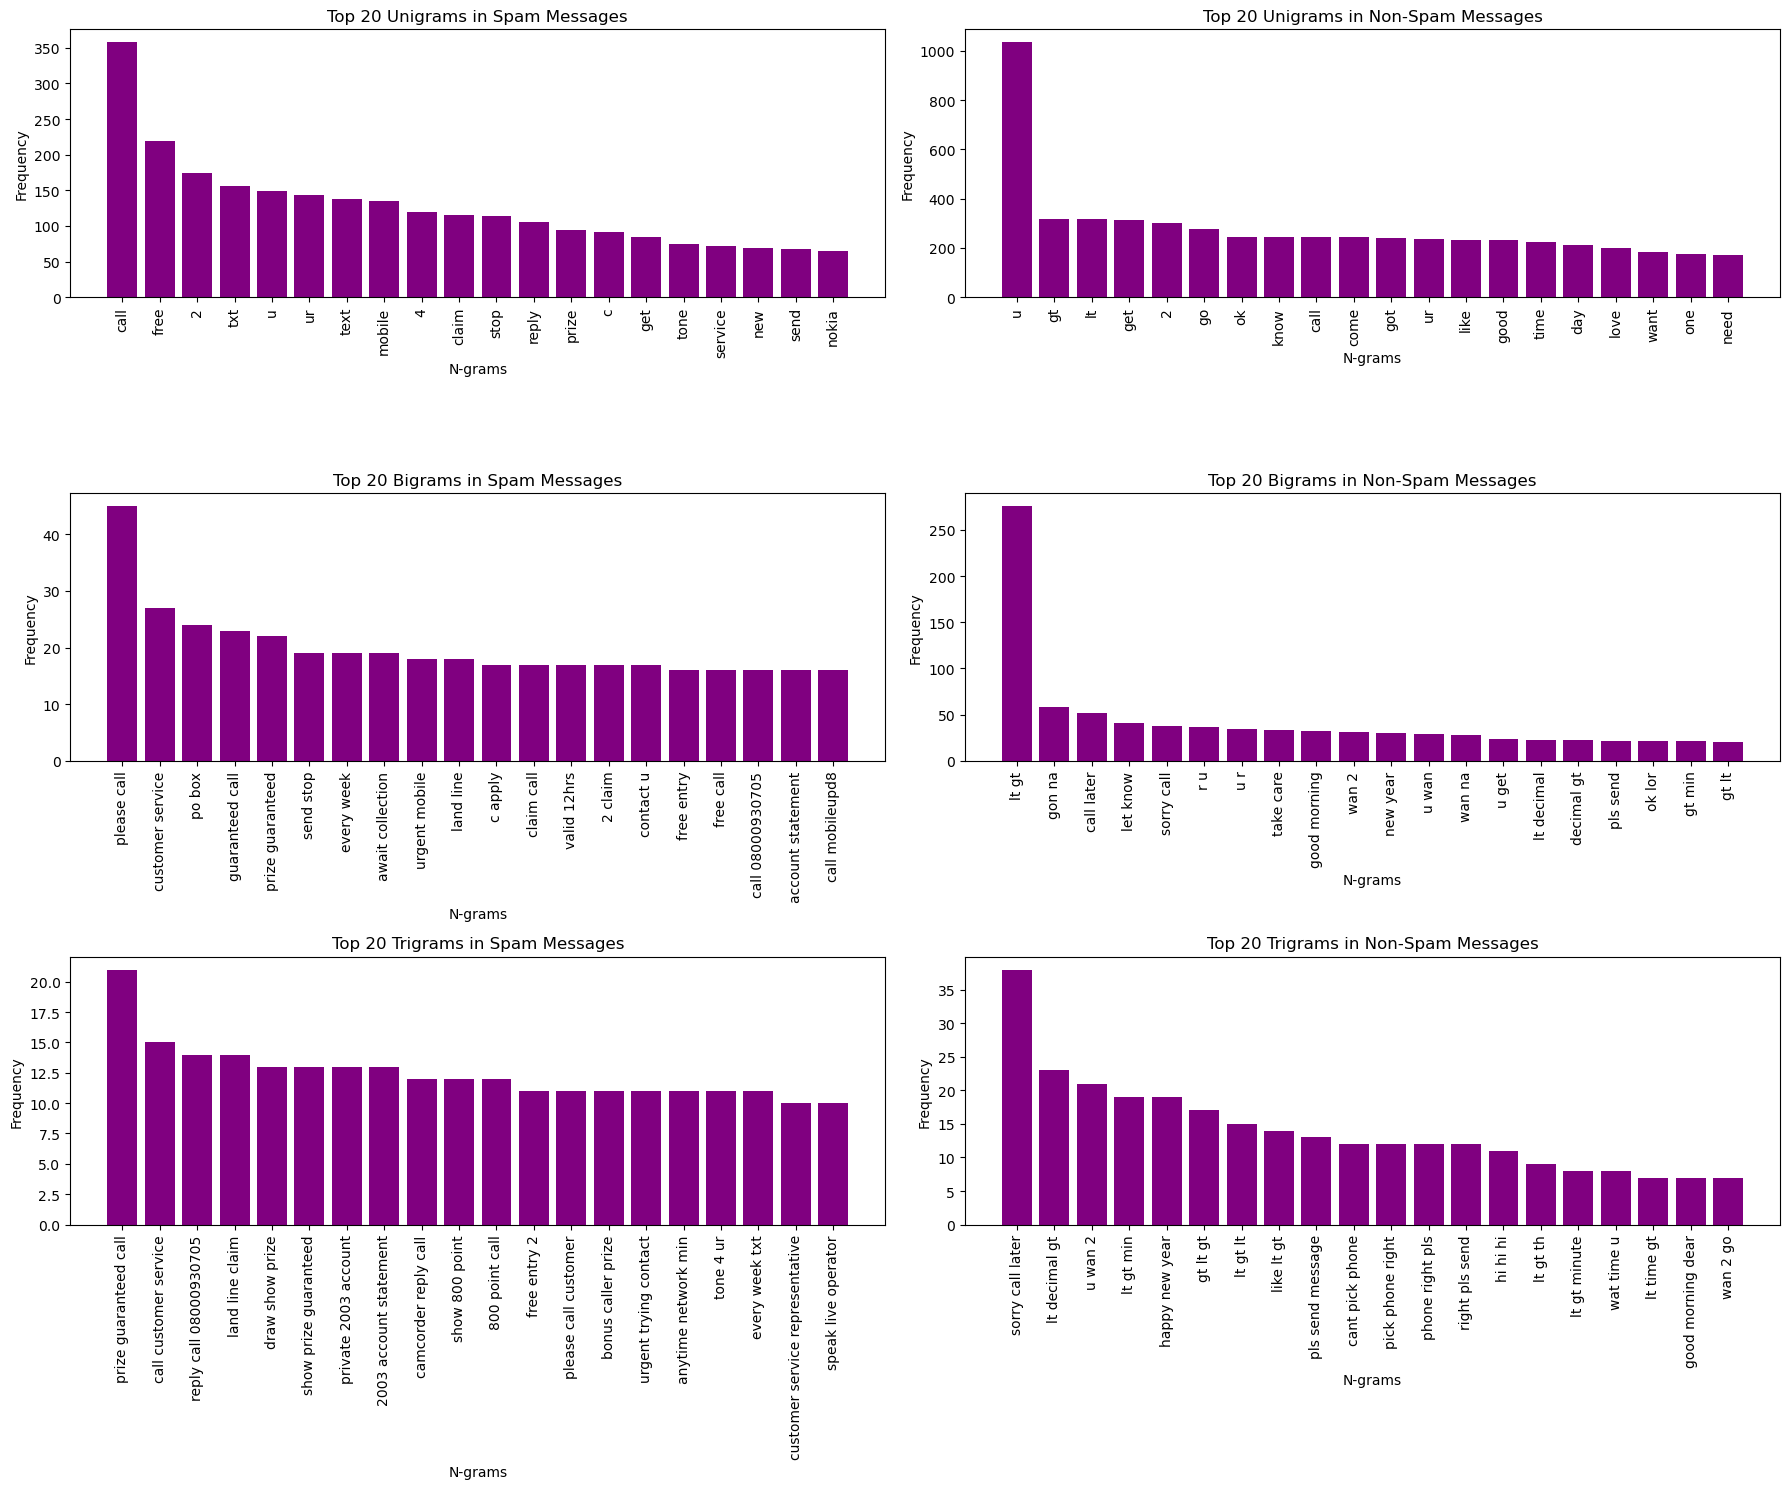

In [10]:
def plot_ngram_subplots(spam_unigrams, non_spam_unigrams, spam_bigrams, non_spam_bigrams, spam_trigrams, non_spam_trigrams):
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))  # 3 rows for unigrams, bigrams, trigrams; 2 columns for spam, non-spam

    # List of all data and titles
    data = [
        (spam_unigrams, 'Top 20 Unigrams in Spam Messages'),
        (non_spam_unigrams, 'Top 20 Unigrams in Non-Spam Messages'),
        (spam_bigrams, 'Top 20 Bigrams in Spam Messages'),
        (non_spam_bigrams, 'Top 20 Bigrams in Non-Spam Messages'),
        (spam_trigrams, 'Top 20 Trigrams in Spam Messages'),
        (non_spam_trigrams, 'Top 20 Trigrams in Non-Spam Messages')
    ]
    
    # plotting loop
    for ax, (frequencies, title) in zip(axes.flatten(), data):
        top_items = frequencies.most_common(20)
        labels, values = zip(*top_items)
        
        # convert labels for bigrams/trigrams from tuples to strings
        if isinstance(labels[0], tuple):
            labels = [' '.join(label) for label in labels]
        
        ax.bar(labels, values)
        ax.set_title(title)
        ax.set_xlabel('N-grams')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=90)  
        
    plt.tight_layout()
    plt.show()

# Call the function with your frequency data
plot_ngram_subplots(spam_unigrams, non_spam_unigrams, spam_bigrams, non_spam_bigrams, spam_trigrams, non_spam_trigrams)

## Train Test Split

In [11]:
df.head()

,is_spam,message,num_character,num_word,num_sentence,message_transformed
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think go usf life around though


In [12]:
# assign predicting and target variables
X = df['message_transformed']
y = df['is_spam']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Modelling

## TF-IDF Vectorization

Using `CountVectorizer` and `min_df`, we've only enforced that words that appear in less than 5 documents should be discarded, while all other words are kept. In essence we are saying that words that appear less frequently may not be so important.

There is, however, also the argument that words that appear infrequently are VERY important. Using either "good" or "bad" might be very common, but more uncommon words like "terrific" or "atrocious" should be given more weight.  

For this purpose we have the TF-IDF Vectorizer, which is composed of multiplying the following: 

1. **Term Frequency (TF)** - which is the number of times a given word appears in a document (message), this is the same as the content of our bag-of-words document-term matrix;
2. **Inverse Document Frequency (IDF)** - Inverse of the number of documents (message) a given word appears in.

TF-IDF is scored between 0 and 1. The higher the numerical weight value, the rarer the term. The smaller the weight, the more common the term. 

Assuming we have a collection of tokens $[t_1, t_2, t_3, ..., t_n]$, and a collection of documents $D = [d_1, d_2, d_3, ... d_m]$ the overall formula for a TF-IDF score is:

$$TF(t_i, d_j) \times IDF(t_i, D)$$

Where:
* $TF(t_i, d_j)$ is the term frequency of token $i$ in document $j$. 
* $IDF(t_i, D)$ is the inverse document frequency of term $i$ in all documents (corpus). In the simplest case it is:

$$\frac{len(D)}{len(\{\text{all $d_k$ such that $t_i \in d_k$} \})+1}$$

For example:
* When a 100-word document contains the term “Chipotle” 5 times, the TF for the word ‘Chipotle’ is TF(Chipotle) = 5/100 i.e. 0.05
* Say the size of the corpus is 2000, and we calculate that "Chipotle" occurs in 700 of those document, then IDF(Chipotle) = 2000/700 = 2.86

$$ \text{TF-IDF(Chipotle)} = 0.05 \times 2.857 = 0.143 $$

* What happens if "Chipotle" occurs in only 200 of those document? Then IDF(Chipotle) = 2000/200 = 10

$$ \text{TF-IDF(Chipotle)} = 0.05 \times 10 = 0.5 $$





In simple words, instead of our document-term matrix containing just the count of each token, it now contains a weight. 

- Words that are very common across documents are going to have their count be scaled down 
- Words that are less common across documents are going to have their count be scaled up

That way, when any model is trying to learn whether a word is predictive of sentiment, it will put more focus on the less common words.

In the following modelling process, TF-IDF will be incorporated within the cross-validation to prevent data leakage.

## Evaluation Metrics

In the context of spam detection, precision and recall are two critical metrics used to evaluate the effectiveness of a model. They help to understand how well the model performs in identifying spam emails compared to how many it should ideally identify.

**Precision:**<br>
Precision measures the accuracy of the positive predictions. It is the percentage of messages that the model correctly identified as spam out of all the messages it labeled as spam. High precision means that when the model predicts a message to be a spam, it is very likely to be correct. This is curcial because it minimizes the number of legitimate messages (ham) that are incorrectly classified as spam.

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

**Recall:**<br>
Recall (as known as sensitivity) measures the model's ability to find all the actual spams. It is the percentage of actual spam messages that were correctly identified by the model. High recall means that the model is effective at catching spam messages, reducing the risk of spam emails getting through to the user's inbox.

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

**F1 Score**<br>
The F1 Score is the harmonic mean of precision and recall. This formula ensures that the F1 Score can only have a high value if both precision and recall are high. It effectively captures the trade-offs between precision and recall, providing a single score that balances both dimensions.

$$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

There is typically a trade-off between precision and recall. This trade-off can be managed by adjusting the predicting threshold, depending on stakeholder's specific needs. The F1 Score is used in various scenarios such as:

- Evaluating models in binary classification tasks, especially when classes are imbalanced.
- Comparing model performance where false negatives and false positives have significant costs (e.g., fraud detection, disease screening, spam detection, etc).
- Situations where precision and recall are equally important.

For this project, I will use **F1** as the evaluation metric, you can always experiment on your own.

## Model Comparison

One of the key advantages of **ROC-AUC** is that it evaluates the performance of a model across all classification thresholds, rather than at a single threshold. This means the metric gives an overall picture of the model's ability to discriminate between the positive and negative classes regardless of the specific cutoff point used to classify instances as positive or negative. 

ROC-AUC is generally considered robust against class imbalance. This is because the ROC curve plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity), metrics that are inherently balanced between classes. AUC provides a single measure summarizing performance across all possible class distributions. On this regard, AUC provides a scalar value that can be used to compare the performance of different models directly. This is particularly useful in model selection where multiple competing models are evaluated using cross-validation. A higher AUC value indicates a model with better overall performance at distinguishing between the classes across all thresholds.

In [ ]:
# list of models to try
models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# dictionary to store cross validation results
cv_results = {}

# setup Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform cross-validation
for model_name, model in models.items():
    
    # start time
    start_time = time.time()
    
    # setup a pipeline with TF-IDF
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=5)),
        ('model', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    cv_results[model_name] = np.mean(scores)
    
    # model run time
    duration = time.time() - start_time
    
    print(f"\nCross Validation for {model_name} completed in {duration:.2f} seconds:")
    print(f"Average AUC: {cv_results[model_name]:.4f}")

# get best performing model
best_model_name = max(cv_results, key=cv_results.get)
print(f"\nBest performing model: {best_model_name} with Average AUC: {cv_results[best_model_name]:.4f}")

SVC has the highest AUC score of 0.9875. However, it is also important to consider the training time, SVC takes significantly longer to train compared some other models. For further tuning, it would be logical to preceed with SVC since it exhibits the highest AUC score, indicating it has the best performance in terms of distinguishing between the positive and negative classes. However, if training cost is a crucial factor, you might also consider the Naive Bayes or Logistic Regression models. Naive Baye is the most efficient model, for this notebook, I will fine tune both SVC and Naive Bayes.

# Hyperparameter Tuning

## SVC

In [ ]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])
    
param_grid_svc = {
    'tfidf__min_df': [2, 5, 10],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],   # unigrams, bigrams, or trigrams
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
    'svc__kernel':['rbf', 'linear', 'sigmoid', 'poly'],
    'svc__degree': [2 ,3, 4],
    'svc__gamma': ['scale', 'auto', 0.1, 1],
    'svc__class_weight': ['balanced']  # 'balanced' automatically adjusts weights
}

# set up stratifiedkfold for cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define a custom scorer for precision to imporve minority class detection
f1_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)

# instantiate GridSearchCV
gs_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=skf, scoring=f1_scorer, n_jobs=-1, verbose=1)

gs_svc.fit(X_train,y_train)

In [ ]:
print(f"Best parameters: {gs_svc.best_params_}.")
print(f"Best Score: {gs_svc.best_score_}.")

In [69]:
svc_opt = Pipeline([ 
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1,2))),  
    ('model', SVC(
        probability=True,
        C=10,
        class_weight='balanced', 
        degree=2, 
        gamma=0.1, 
        kernel='rbf'))
])

svc_opt.fit(X_train,y_train) 

y_train_pred = svc_opt.predict(X_train)

y_test_pred = svc_opt.predict(X_test)
y_test_pred_proba = svc_opt.predict_proba(X_test)[:,1]

train_accuracy = accuracy_score(y_train, y_train_pred)
validation_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {validation_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Train Accuracy: 1.00
Validation Accuracy: 0.98
Precision: 0.96
Recall: 0.88
F1 Score: 0.92
ROC AUC: 0.98


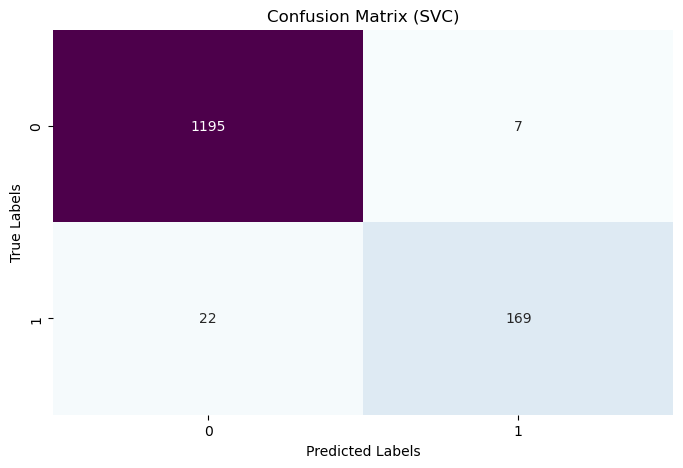

In [70]:
# instantiate the confusion matrix
cm_svc = confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(cm_svc, annot=True, fmt="g", cmap='BuPu', cbar=False)
plt.title("Confusion Matrix (SVC)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Naive Bayes

In [13]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('NB', MultinomialNB())
])
    
param_grid_nb = {
    'tfidf__min_df': [2, 5, 10],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],   # unigrams, bigrams, or trigrams
    'NB__alpha': [0.001, 0.01, 0.1, 1, 10],
    'NB__fit_prior': [True, False]
}

# set up stratifiedkfold for cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define a custom scorer for precision to imporve minority class detection
f1_scorer = make_scorer(f1_score, pos_label=1, zero_division=0)

# instantiate GridSearchCV
gs_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=skf, scoring=f1_scorer, n_jobs=-1, verbose=1)

gs_nb.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('NB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'NB__alpha': [0.001, 0.01, 0.1, 1, 10],
                         'NB__fit_prior': [True, False],
                         'tfidf__min_df': [2, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring=make_scorer(f1_score, pos_label=1, zero_division=0),
             verbose=1)

In [14]:
print(f"Best parameters: {gs_nb.best_params_}.")
print(f"Best Score: {gs_nb.best_score_}.")

Best parameters: {'NB__alpha': 0.01, 'NB__fit_prior': True, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}.
Best Score: 0.9289249703063517.


In [15]:
nb_opt = Pipeline([ 
    ('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1,2))),  
    ('model', MultinomialNB(
        alpha=0.01,
        fit_prior=True))
])

nb_opt.fit(X_train,y_train) 

y_train_pred = nb_opt.predict(X_train)

y_test_pred = nb_opt.predict(X_test)
y_test_pred_proba = nb_opt.predict_proba(X_test)[:,1]

train_accuracy = accuracy_score(y_train, y_train_pred)
validation_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {validation_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Train Accuracy: 0.99
Validation Accuracy: 0.98
Precision: 0.96
Recall: 0.86
F1 Score: 0.91
ROC AUC: 0.98


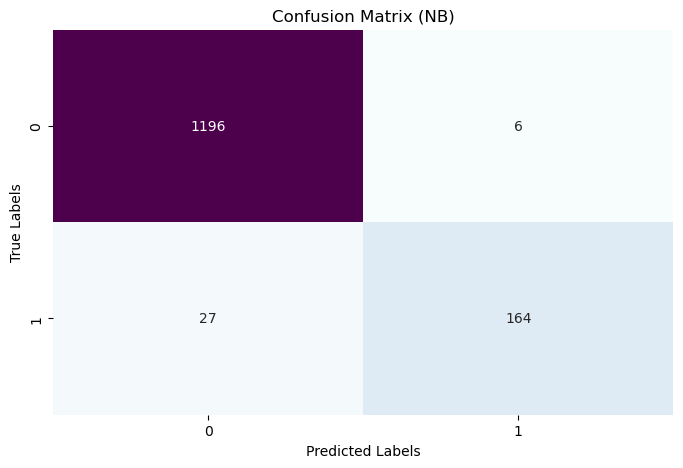

In [16]:
# instantiate the confusion matrix
cm_nb = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))

# plot the confusion matrix
sns.heatmap(cm_nb, annot=True, fmt="g", cmap='BuPu', cbar=False)
plt.title("Confusion Matrix (NB)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# LSTM

**LSTM** is a special kind of Recurrent Neural Network (RNN) capable of learning long-term dependencies. LSTM was designed to avoid the long-term dependency problem, making it effective at capturing information in sequences of data, such as text for spam detection.
1. **Sequence Processing:** LSTMs process text data sequentially, preserving a memory of previous inputs thanks to its internal state (memory cell), which allows it to exhibit dynamic temporal behavior. This is particularly useful in spam detection where the sequence and context of words can determine whether a message is spam.

2. **Handling Long Texts:** Traditional RNNs often struggle with vanishing or exploding gradients when dealing with long sequences, but LSTMs manage these issues with their gate mechanisms (input, forget, and output gates), making them more stable and efficient for tasks like spam detection where message length varies significantly.

3. **Learning Dependencies:** LSTMs can learn which words and phrases in an email contribute most to its classification as spam or not spam by remembering past data inputs for an extended period and selectively forgetting irrelevant data through the forget gate.

## Tokenization and Vectorization

In [17]:
# keep the top 10,000 words
max_words = 10000
# maximum length of sequences
max_len = 200

# instantiate the tokenizer
tokenizer = Tokenizer(num_words=max_words)
# fit the tokenizer
tokenizer.fit_on_texts(X_train)

# convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad sequences to ensure uniform input size
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

In [18]:
# instantiate LSTM
lstm = Sequential()
lstm.add(Embedding(input_dim=max_words, output_dim=50, input_length=max_len))
lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm.add(Dropout(0.5))
lstm.add(LSTM(32))
lstm.add(Dropout(0.5))
lstm.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
lstm.add(Dense(1, activation='sigmoid'))

# compile
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.build(input_shape=(None, max_len))
lstm.summary()

2024-04-15 15:37:37.885719: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           500000    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                        

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',     # monitor validation loss
    patience=3,             # number of epochs with no improvement after which training will be stopped
    verbose=1,              
    mode='min',             # stop training when the quantity monitored has stopped decreasing
    restore_best_weights=True  # restore model weights from the epoch with the best value
)

# train the model
history = lstm.fit(X_train_padded, y_train, 
                    epochs=10, 
                    batch_size=64, 
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/10
53/53 [==============================] - 29s 459ms/step - loss: 0.7780 - accuracy: 0.8594 - val_loss: 0.4672 - val_accuracy: 0.8744
Epoch 2/10
53/53 [==============================] - 54s 1s/step - loss: 0.3209 - accuracy: 0.9821 - val_loss: 0.2717 - val_accuracy: 0.9809
Epoch 3/10
53/53 [==============================] - 74s 1s/step - loss: 0.1622 - accuracy: 0.9958 - val_loss: 0.1880 - val_accuracy: 0.9797
Epoch 4/10
53/53 [==============================] - 55s 1s/step - loss: 0.1106 - accuracy: 0.9928 - val_loss: 0.1645 - val_accuracy: 0.9773
Epoch 5/10
53/53 [==============================] - 64s 1s/step - loss: 0.0607 - accuracy: 0.9988 - val_loss: 0.1329 - val_accuracy: 0.9821
Epoch 6/10
53/53 [==============================] - 65s 1s/step - loss: 0.0380 - accuracy: 0.9997 - val_loss: 0.1487 - val_accuracy: 0.9797
Epoch 7/10
53/53 [==============================] - 65s 1s/step - loss: 0.0283 - accuracy: 0.9997 - val_loss: 0.1231 - val_accuracy: 0.9809
Epoch 8/10
53/53 

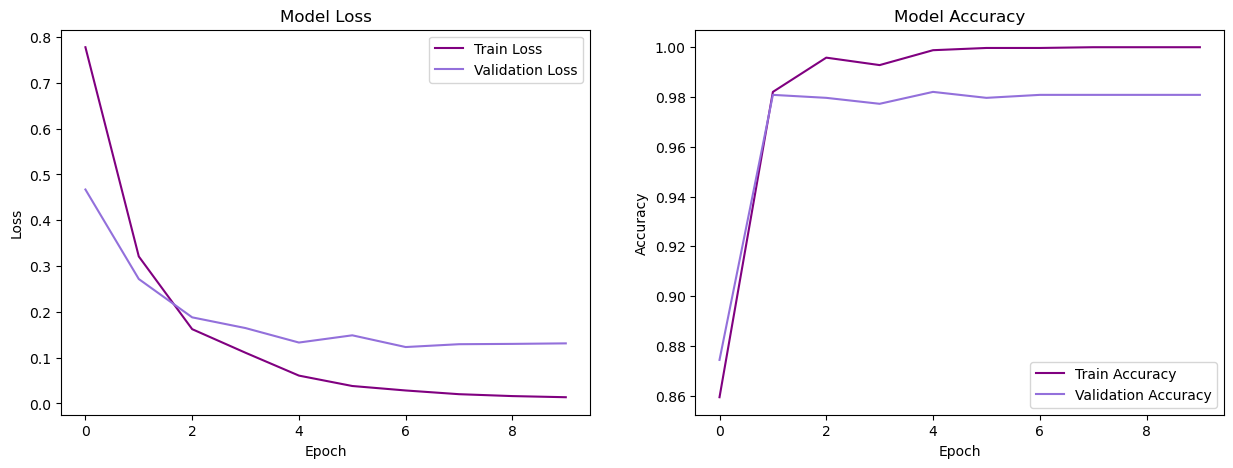

In [21]:
plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [25]:
# predict probabilities on train set
y_pred_proba_train = lstm.predict(X_train_padded).flatten()
# convert probabilities to binary predictions
y_pred_train = (y_pred_proba_train > 0.5).astype('int32')

# predict probabilities on test set
y_pred_proba = lstm.predict(X_test_padded).flatten()
# convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype('int32')

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

Train Accuracy: 0.9962
Test Accuracy: 0.9727
Test Precision: 0.9636
Test Recall: 0.8325
Test F1 Score: 0.8933
Test ROC AUC: 0.9772


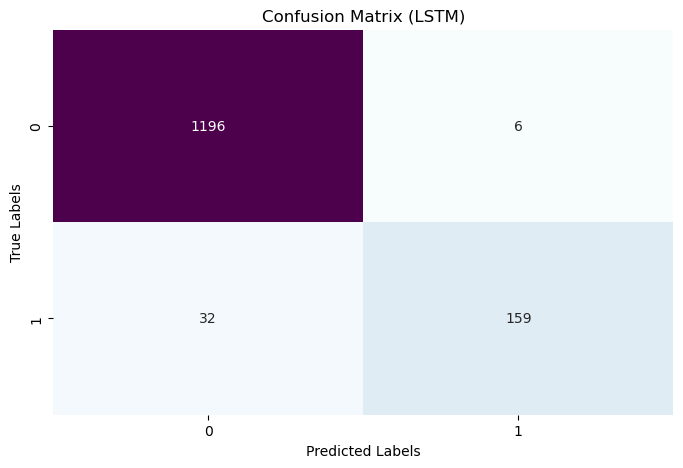

In [26]:
# instantiate the confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))

# plot the confusion matrix
sns.heatmap(cm_lstm, annot=True, fmt="g", cmap='BuPu', cbar=False)
plt.title("Confusion Matrix (LSTM)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## LSTM with GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Traning is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcae interesting linear substructures of the word vector space. Essentially, it is a method to convert words into numerical vectors, capturing semantic meanings based on the global statistical information of a corpus.

1. **Semantic Understanding:** GloVe embeddings capture semantic relationships between words by analyzing the frequency with which words co-occur in large text corpora. This can help a spam detection model understand content with similar semantic meanings even if exact words differ.
2. **Feature Input:** By transforming text data into numerical form via GloVe embeddings, machine leaning models can more effectively learn patterns that distinguish spam from non-spam. This numerical representation provides a fixed-length input vector for each text, which is critical for processing with most machine learning algorithms.
3. **Pre-trained Advantage:** Using pre-trained GloVe vectors, which have been developed using extensive and diverse datasets, can significantly boost the model's performance with less computational resource expenditure on training word vectors from scratch.

Download the GloVe pre-trained word vectors from: https://nlp.stanford.edu/projects/glove/

In [27]:
def load_glove_model(glove_filepath):
    embedding_index = {}
    file = open(glove_filepath)
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
    return embedding_index

# Example: Loading the GloVe embeddings from the downloaded file
glove_embeddings = load_glove_model('glove.6B.100d.txt')

In [28]:
# Determine the vocabulary size and the dimension of embeddings
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # This should match the dimension of the GloVe embeddings you are using

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with GloVe vectors for the words found in the tokenizer's vocabulary
for word, idx in tokenizer.word_index.items():
    if idx < max_words:  # Only fill up to num_words
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [63]:
# instantiate LSTM
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_len,
                    weights=[embedding_matrix],
                    trainable=False))
lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
lstm.add(GlobalMaxPool1D())
lstm.add(BatchNormalization())
lstm.add(Dropout(0.5))
lstm.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
lstm.add(Dropout(0.5))
lstm.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
lstm.add(Dense(1, activation='sigmoid'))

# compile
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.build(input_shape=(None, max_len))
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          643700    
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 256)         234496    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [64]:
early_stopping = EarlyStopping(
    monitor='val_loss',     # monitor validation loss
    patience=3,             # number of epochs with no improvement after which training will be stopped
    verbose=1,              
    mode='min',             # stop training when the quantity monitored has stopped decreasing
    restore_best_weights=True  # restore model weights from the epoch with the best value
)

# train the model
history = lstm.fit(X_train_padded, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
53/53 [==============================] - 16s 250ms/step - loss: 2.3231 - accuracy: 0.9112 - val_loss: 2.1131 - val_accuracy: 0.9605
Epoch 2/50
53/53 [==============================] - 21s 404ms/step - loss: 1.3637 - accuracy: 0.9668 - val_loss: 1.2675 - val_accuracy: 0.9713
Epoch 3/50
53/53 [==============================] - 30s 567ms/step - loss: 0.8078 - accuracy: 0.9770 - val_loss: 0.7990 - val_accuracy: 0.9641
Epoch 4/50
53/53 [==============================] - 36s 688ms/step - loss: 0.4826 - accuracy: 0.9809 - val_loss: 0.4977 - val_accuracy: 0.9797
Epoch 5/50
53/53 [==============================] - 36s 685ms/step - loss: 0.3069 - accuracy: 0.9838 - val_loss: 0.3370 - val_accuracy: 0.9761
Epoch 6/50
53/53 [==============================] - 32s 595ms/step - loss: 0.2080 - accuracy: 0.9847 - val_loss: 0.2255 - val_accuracy: 0.9833
Epoch 7/50
53/53 [==============================] - 32s 596ms/step - loss: 0.1429 - accuracy: 0.9889 - val_loss: 0.1808 - val_accuracy: 0.9713

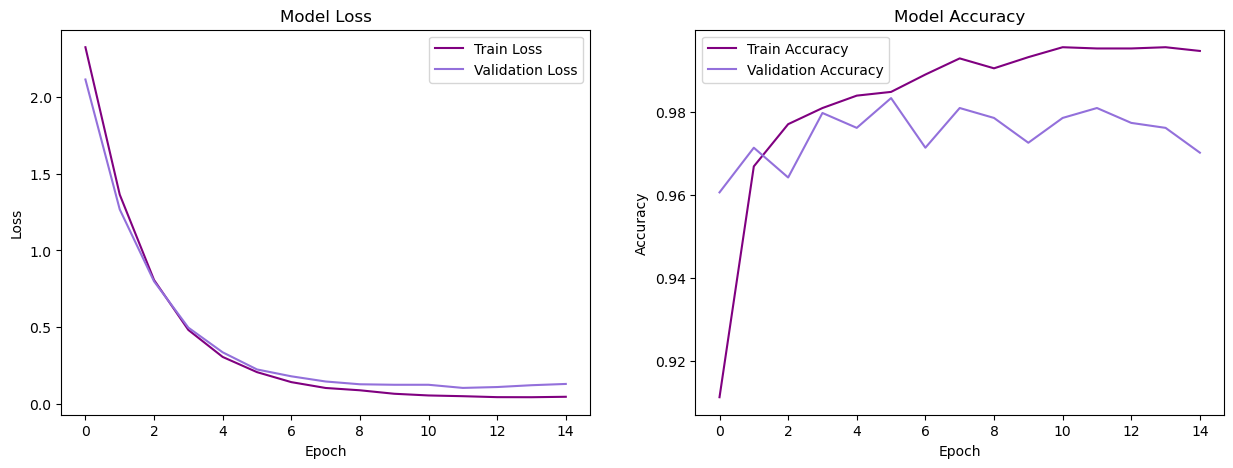

In [65]:
plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [66]:
# predict probabilities on train set
y_pred_proba_train = lstm.predict(X_train_padded).flatten()
# convert probabilities to binary predictions
y_pred_train = (y_pred_proba_train > 0.5).astype('int32')

# predict probabilities on test set
y_pred_proba = lstm.predict(X_test_padded).flatten()
# convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype('int32')

# Calculate metrics
train_accuracy = accuracy_score(y_train,y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

Train Accuracy: 0.9952
Test Accuracy: 0.9763
Test Precision: 0.9817
Test Recall: 0.8429
Test F1 Score: 0.9070
Test ROC AUC: 0.9821


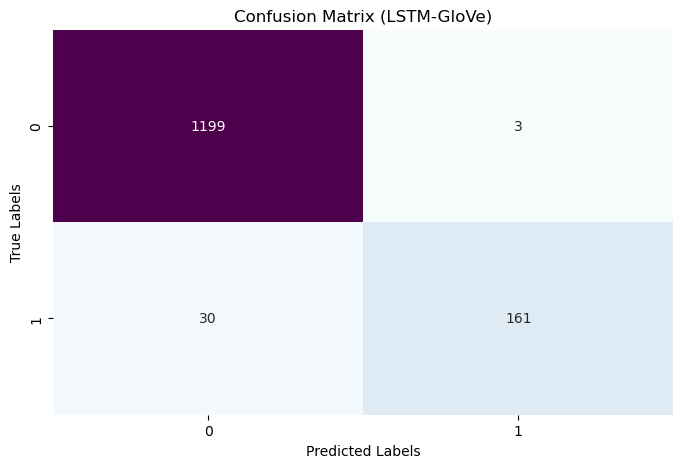

In [67]:
# instantiate the confusion matrix
cm_glove = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 5))

# plot the confusion matrix
sns.heatmap(cm_glove, annot=True, fmt="g", cmap='BuPu', cbar=False)
plt.title("Confusion Matrix (LSTM-GloVe)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Conclusion

Let's look at the confusion matrix of each model, and see how they perform.

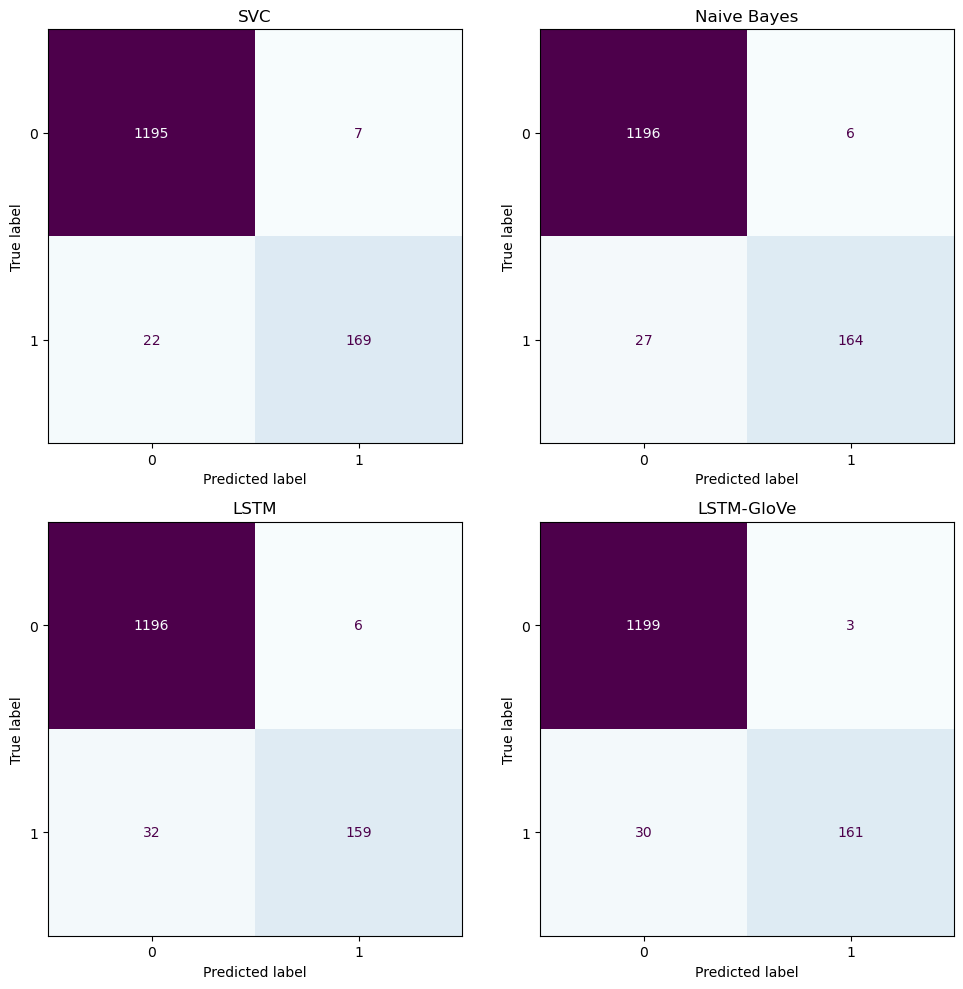

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

titles = ['SVC', 'Naive Bayes', 'LSTM', 'LSTM-GloVe']

for axs, cm, title in zip(ax.flatten(), [cm_svc, cm_nb, cm_lstm, cm_glove], titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs, cmap='BuPu', colorbar=False)
    axs.title.set_text(title)

plt.tight_layout()
plt.show()

While both models show high performance, the SVC model has a slightly better balance between precision and recall, resulting in a higher F1 Score. This means that the SVC model has a better harmonic mean between the rate of correctly predicted spam messages and the overall accuracy of spam predictions. The difference in performance is relatively small but could be significant depending on the cost of false positives and false negatives in your specific application.

**Choosing a Model:**<br>
- If minimizing false negatives is more important, the SVC model is preferable due to its higher recall.
- If precision is more critical (minimizing the risk of marking legitimate emails as spam), the LSTM with GloVe embeddings has an upper edge.